In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import networkx as nx

from urllib.request import urlopen
from bs4 import BeautifulSoup

import re
from itertools import combinations
from collections import Counter

from IPython.display import Image
from IPython.core.display import display, HTML

from nltk.tokenize import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from textblob import TextBlob

In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))

# Hugo Steinhaus Center

Mathematics, pure and applied, is often perceived by the community of users as increasingly isolated from its sister sciences and from the needs of industry. The goal of the Hugo Steinhaus Center is to organize, encourage and support research on and education in stochastic techniques as applied in science and technology. A study of related theoretical mathematical issues is an integral part of the Center's research. Random and chaotic phenomena provide the unifying intelectual theme of the Center, and represent an area where certain frontiers of mathematics, economics, natural sciences, and engineering can fully overlap on problems that are fundamental and yet have practical implications in finance and technology. A feature of the Center is a synthesis of viewpoints of mathematicians, economists, computer scientists, physicists, chemists and engineers, working in the Center on equal footing. 
<br> <br>
Hugo Steinhaus Center has a lot of members with high scientific degrees. They can publish articles and affiliate them to this center. Goal of this analysis is to: get all publications from main HSC website: http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html, detect which authors of publications are affiliated with HSC, analyse such a dataset, and create a graph on which every member of HSC is represented as a node, an edge means paper co-authored by these nodes, and weights that mean total number of common papers.

## Scrapping publications from website

In [3]:
def get_request(url):
    """
    Gets html text from url
    
    Input:
        url: string - website url
    
    Output:
        soup: bs4.BeautifulSoup - bs4 object with html text
    """
    request = urlopen(url)
    soup = BeautifulSoup(request.read(), 'lxml')
    
    return soup

In [4]:
def scrap_research_papers(soup_rows):
    """
    Finds all rows from specific website in module "Research papers"
    
    Input:
        soup_rows: list - list of rows from bs4 object
        
    Output:
        rows: list - list of strings, which are rows from "Research papers" module       
    """
    rows = []
    active = False
    for row in soup_rows:
        if "Research papers:" in row:
            rows.append(row)
            active = True
        elif "Research reports:" in row:
            active = False
            break
        if active:
            rows.append(row)
            
    return rows

In [5]:
def find_publication(research_papers):
    """
    Detects if one row contains publication based on dates inside a single row
    
    Input:
        research_papers: list - list of strings, which are rows from "Research papers" module   
        
    Output:
        entries: list - list of publications
    """
    entries = []
    for i in range(len(research_papers)):
        if re.search(r'\s[(]199[0-9][)]\s|\s[(]20[0-2][0-9][)]\s', research_papers[i]) != None:
            entries.append(research_papers[i])  
            
    return entries

In [6]:
def hsc_researchers(soup):
    """
    Finds all researchers from the Hugo Steinhaus Center, funtion searching for tags <b> in html text
    
    Input:
        soup: bs4.BeautifulSoup - bs4 object with html text
        
    Output:
        hsc_researchers: list - list of Hugo Steinhaus Center scientists
    """
    hsc_researchers = [b.string for b in soup.findAll('b')]
    
    return hsc_researchers

In [7]:
url = 'http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html'
soup = get_request(url)
research_papers = scrap_research_papers(soup.text.split('\n'))[3:]
publications = find_publication(research_papers)
hsc_researchers = hsc_researchers(soup)

## Preparation data for DataFrame and Graph

In [8]:
publications = find_publication(research_papers)

In [9]:
def change_values(value, authors, possibilities):
    """
    Changes possibilities names for a one given proper value in list of authors
    
    Input:
        value: str - a correct name of publicist
        authors: list - lis to of authors to check
        possibilities: list - list of possible mistakes to correct
    
    Output:
        corrected list of authors
    """
    authors = [value if author in possibilities else author for author in authors]
    return authors

In [10]:
def prepare_data(publications):
    """
    Collecting data for creating graphs - co_authors - to create nodes and edges for networkx graph object; articles to create DataFrame from Pandas
    
    Input:
        publications: list - list of publications
        
    Output:
        articles: list - information about authors, year published, title and number of co-authors
        co_authors: list - information about co-authors to create graph
    """
    weirdos = ['SPIE Optical', 'J. Stat. Mech.', 'Physical Review E', 'Annals of Physics', 'Physical Review Letters']
    articles = []
    co_authors = []
    for i in range(len(publications)):
        processing = True
        for weird in weirdos:
            if weird not in publications[i]:
                processing = True
            else:
                processing = False
                break
            
        if processing:
            authors = publications[i].split('(')[0].split(',')
            authors = [author.replace(' ', '') for author in authors]
            authors = [author for author in authors if author is not '']
            authors = change_values('A.Wyłomańska', authors, ['A.Wylomanska', 'A.Wyłomanska', 'A.Wylomańska'])
            authors = change_values('H.Loch-Olszewska', authors, ['H.Loch'])
            authors = change_values('G.Żak', authors, ['G.Zak'])
            authors = change_values('A.Stanislavsky', authors, ['A.A.Stanislavsky'])
            authors = change_values('I.Bronshtein', authors, ['I.Bronstein'])
            authors = change_values('J.Masajada', authors, ['J.Masajda'])
            authors = change_values('J.Sokołowski', authors, ['J.Sokolowski'])
            authors = change_values('K.Dębicki', authors, ['K.Debicki'])
            authors = change_values('S.Orzeł', authors, ['S.Orzel'])
            authors = change_values('T.Żórawik', authors, ['T.Zórawik', 'T.Zorawik'])
            authors = change_values('S.Trück', authors, ['S.Trueck'])
            authors = [author.replace(' ', '').replace(',', '') for author in authors]
            no_of_authors = len(authors)
            published = publications[i].split('(')[1][:4]
            title = publications[i].split('(', 1)[1][7:].replace('"', '').replace('\r', '')

            articles.append([authors, published, title, no_of_authors])
            co_authors.append(authors)
        
    return articles, co_authors

In [11]:
articles, co_authors = prepare_data(publications)

## Creating a graph

In [12]:
def create_edges(co_authors, hsc_researchers):
    """
    Creates edges for a graph
    
    Input:
        co_authors: list - information about co-authors to create graph
        hsc_researchers: list - list of Hugo Steinhaus Center scientists
        
    Output:
        edges_count: collections.Counter - number of common papers for each group of people
        links:  list - list of edges and weights for each connection
    """
    edges = []
    for article in co_authors:
        for people in combinations(article, 2):
            if people[0] in hsc_researchers and people[1] in hsc_researchers:
                edges.append(tuple(sorted(people)))
    
    edges_count = Counter(edges)
    
    links = []
    for key, value in edges_count.items():
        links.append([key[0], key[1], value])
        
    return edges_count, links

In [13]:
def create_graph(links, edges_count, title):
    G = nx.Graph()
    G.add_weighted_edges_from(links)
    
    weights = [G[u][v]['weight'] for u,v in G.edges]
    d = dict(G.degree)
    
    low, *_, high = sorted(d.values())
    norm = cm.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='Wistia')
    
    plt.figure(figsize=(20, 10))
    pos=nx.shell_layout(G)
    nx.draw(G, pos, nodelist=d.keys(), node_size=[v * 100 for v in d.values()], node_color=[mapper.to_rgba(i) for i in d.values()])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_count)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_color='darkgreen')
    
    plt.title(title, fontsize=25)
    
    return G

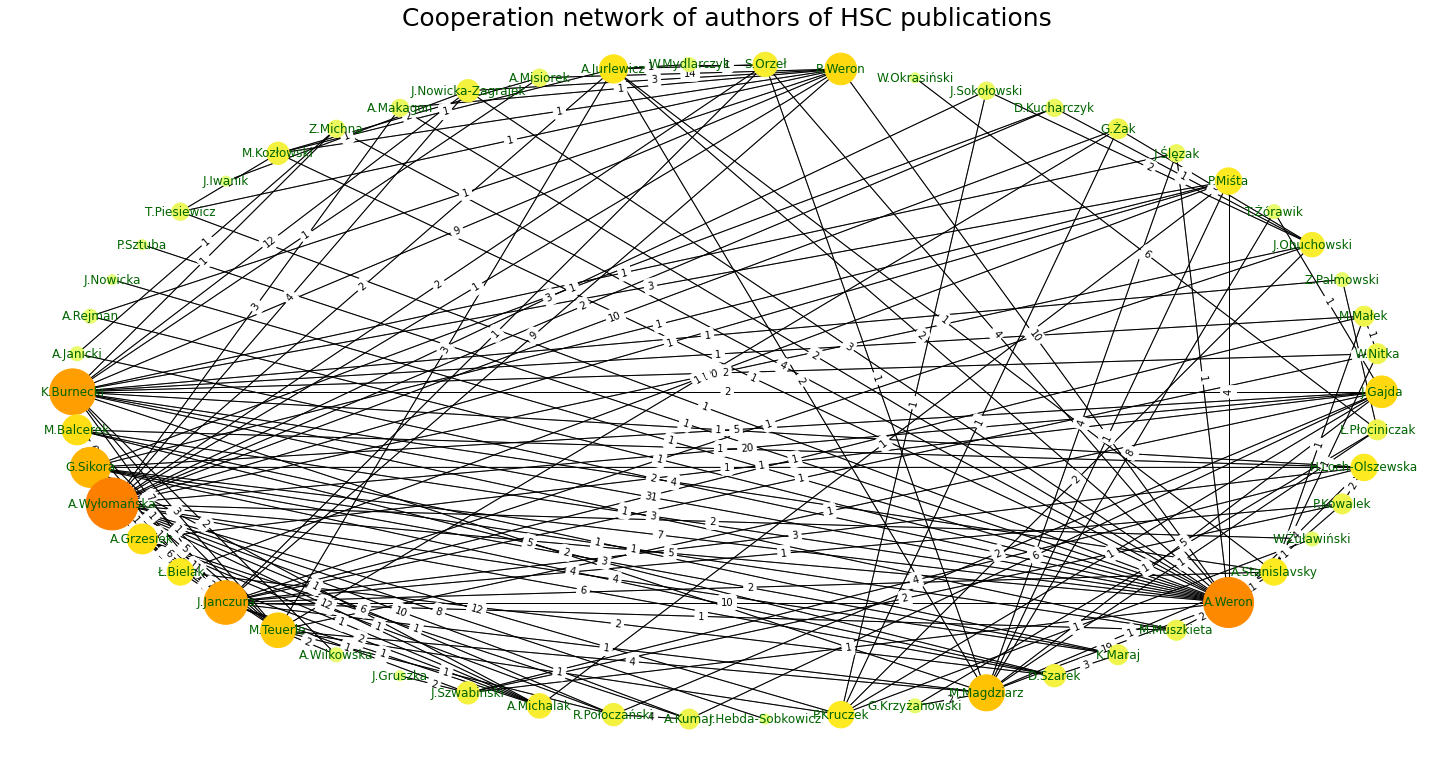

In [14]:
edges_count, links = create_edges(co_authors, hsc_researchers)
G = create_graph(links, edges_count, 'Cooperation network of authors of HSC publications')

## Creating DataFrame

In [15]:
df = pd.DataFrame(articles)
df = df.explode(0).reset_index(drop=True)

hsc = []
for i in range(len(df)):
    if df[0][i] in hsc_researchers:
        hsc.append(True)
    else:
        hsc.append(False)
        
df[1] = df[1].astype(int)
df['HSC'] = hsc
df = df.rename(columns={0: 'Author', 1: 'YearPublished', 2: 'Title', 3: 'NoOfCoAuthors'})

In [16]:
df

,Author,YearPublished,Title,NoOfCoAuthors,HSC
0,M.Balcerek,2021,Discriminating Gaussian processes via quadrati...,4,True
1,K.Burnecki,2021,Discriminating Gaussian processes via quadrati...,4,True
2,G.Sikora,2021,Discriminating Gaussian processes via quadrati...,4,True
3,A.Wyłomańska,2021,Discriminating Gaussian processes via quadrati...,4,True
4,Ł.Bielak,2021,Market risk factors analysis for an internatio...,4,True
...,...,...,...,...,...
1476,W.A.Woyczynski,1995,"Relaxation function in dipolar materials,",3,False
1477,K.Weron,1995,Levy-stable and extreme value distributions in...,4,False
1478,K.Kosmulski,1995,Levy-stable and extreme value distributions in...,4,False
1479,A.Jurlewicz,1995,Levy-stable and extreme value distributions in...,4,True


## What is the number of all articles published?

In [17]:
len(df.groupby(['Title']))

546

## Number of articles published per year?

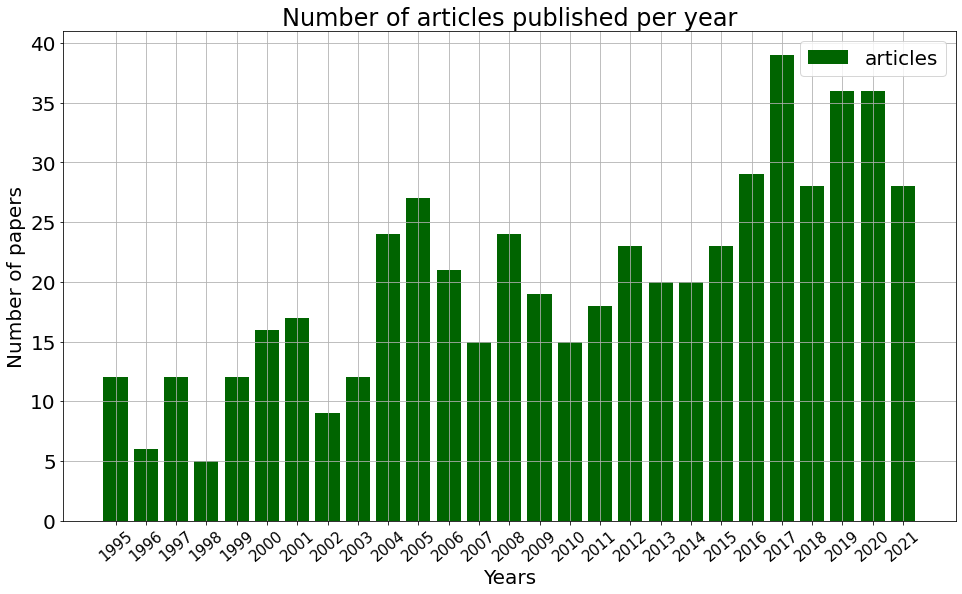

In [18]:
labels = df.groupby(['Title']).last().groupby('YearPublished').count()['Author'].keys()
heights = df.groupby(['Title']).last().groupby('YearPublished').count()['Author'].values

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=20)
plt.figure(figsize=(16, 9))
plt.bar(labels, heights, color='darkgreen', label='articles')
plt.title('Number of articles published per year', fontsize=24)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.xticks(rotation=40)
plt.xticks(range(1995,2022))
plt.legend(prop={'size': 20})
plt.grid()

In the picture above, we present the number of articles published by HSC members in every year since 1995. We can see that the number of publications have increased since the first publication.
It is caused both by the enlarging number of members involved in Hugo Steinhaus Center and higher curiosity of scientific math problems. Publishing articles in technical journals have become more and more popular especially in recent years. 

##  What is the number of HSC members who published articles vs other authors of articles?

In [19]:
hsc_count_members = len(df[df['HSC'] == True].groupby(['Author']).count())

In [20]:
all_members = len(df.groupby(['Author']).count())

In [21]:
hsc_count_members, all_members

(57, 280)

Text(0.5, 1.0, 'Distribution of authors')

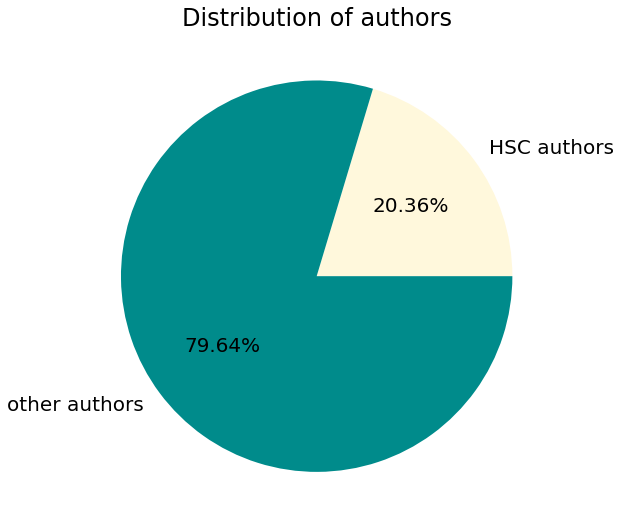

In [22]:
plt.figure(figsize=(16, 9))

pie_vars = ['HSC authors', 'other authors']
pie_values = [hsc_count_members, all_members-hsc_count_members]
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['cornsilk', 'darkcyan'])
plt.title('Distribution of authors', fontsize=24)

Let us divide all authors from HSC publications tabs in people who are members of this organization, and for the others. The number of other authors is significantly bigger but, mostly, there are people who assist during writing articles from different organisations or universities. Meantime, the number of HSC publicists is equal to 57 in comparison to 223.

## What group of people cooperate with each other the most?

In [23]:
def cooperation_plot(number):
    edges = []
    for article in co_authors:
        if len(article) > 1:
            for triple in combinations(article, number):            
                triple = sorted(triple)
                edges.append(tuple(triple))

    edges_count = Counter(edges)

    x, y = [], []
    for pair in edges_count.most_common()[:20]:
        x.append(' '.join(pair[0]))
        y.append(pair[1])

    plt.figure(figsize=(16, 9))
    plt.title(f'The most common papers between {number} co-authors', fontsize=24)
    plt.xlabel('Co-authors', fontsize=20)
    plt.ylabel('Number of common papers', fontsize=20)
    plt.bar(x, y)
    plt.xticks(rotation=90)
    plt.grid()

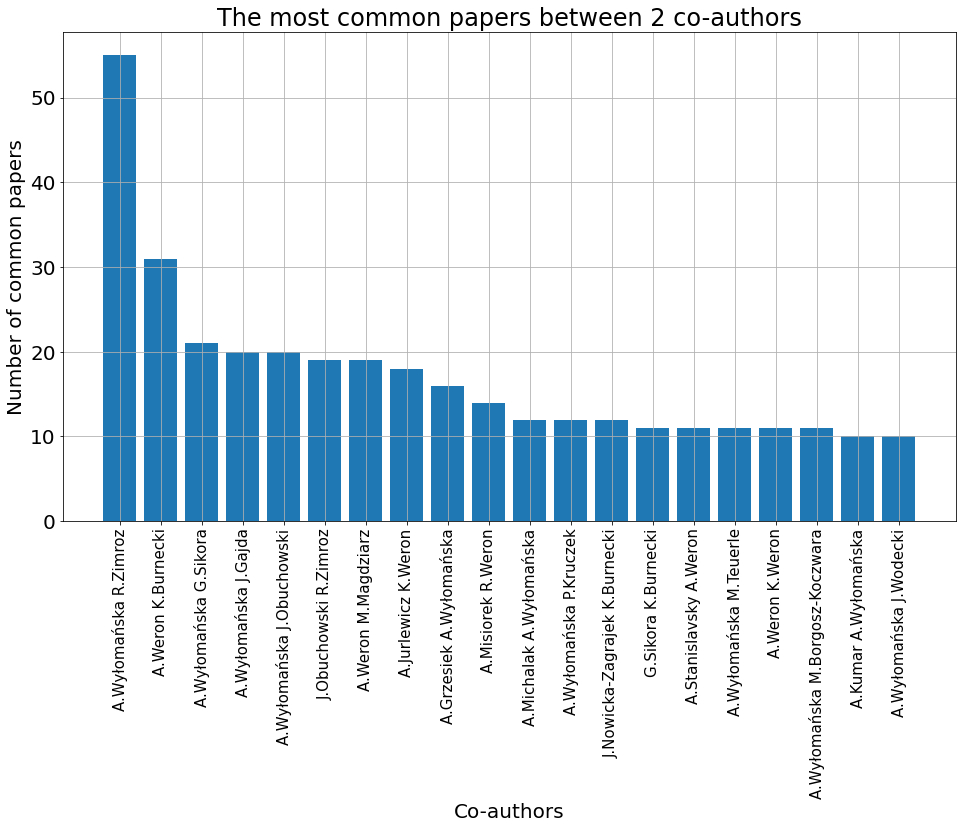

In [24]:
cooperation_plot(2)

From the graph above we can see that the biggest number of common papers has A.Wyłomańska with R.Zimroz. They published almost 60 papers together, however, R.Zimroz doesn't belong to HSC members, therefore considering only people from HSC, K.Burnecki and A.Weron, have the biggest number of common papers (31).

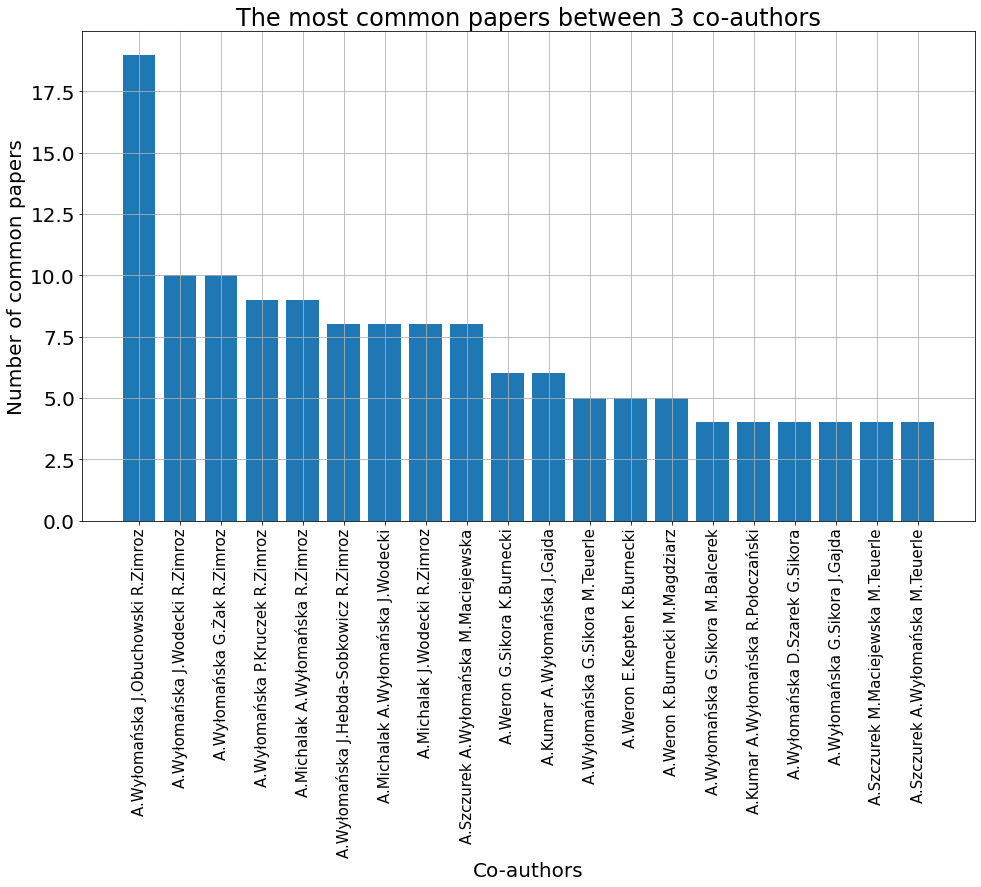

In [25]:
cooperation_plot(3)

What if we consider group of three people instead of pairs? We can see that R.Zimroz and A.Wyłomańska are the most popular - they're engaged in almost every presented co-author group.

## Who published the most articles from Hugo Steinhaus Center?

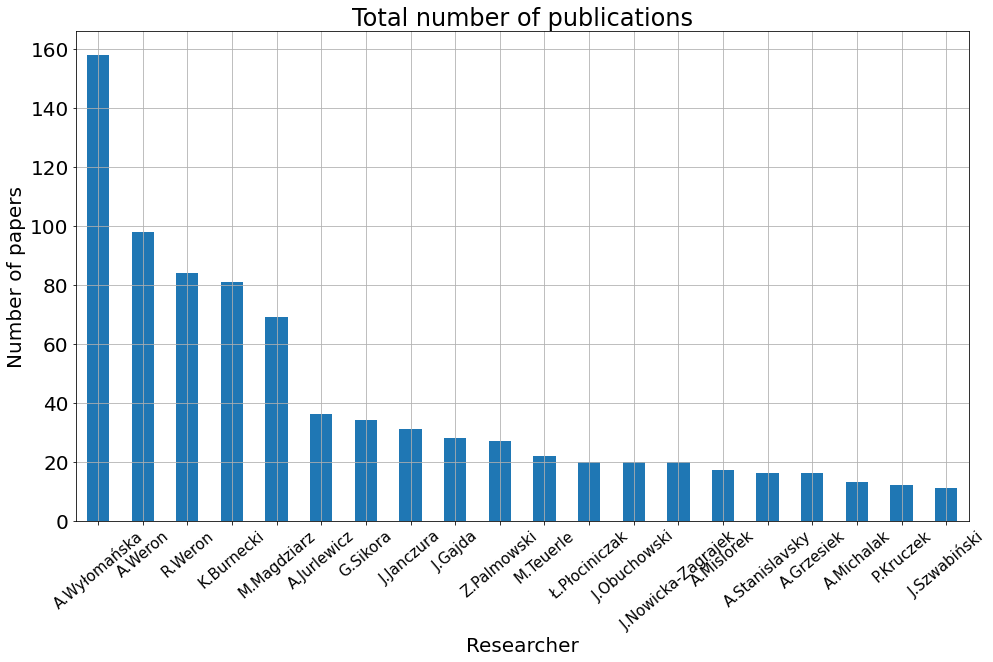

In [26]:
plt.figure(figsize=(16, 9))
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=20)
df[df['HSC'] == True].groupby('Author').sum()['HSC'].sort_values(ascending=False)[0:20].plot.bar()
plt.title('Total number of publications', fontsize=24)
plt.xlabel('Researcher', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.xticks(rotation=40)
plt.grid()

One of the basic questions which appears during this analysis is: what is the number of total publications per one researcher? We can see that A.Wyłomańska has the biggest number of publications and none of other authors has similar result. Next four HSC members are A.Weron, R.Weron, K.Burnecki and M.Magdziarz. Their total number of publications is close to each other. These five authors are the most outstanding in terms of number of publications. They all have at least 60 publications. After them, there is a huge difference between M.Magdziarz and A.Jurlewicz, and other ones have similar numbers of articles. Due to such an enormous number of publications by first five HSC members, let us calculate distribution of written publication divided into those five authors and the others.

## What is a proportion of published articles by the most common publishing researcher?

In [27]:
five_authors = df[df['HSC'] == True].groupby('Author').sum()['HSC'].sort_values(ascending=False)[0:5]

In [28]:
five_authors = five_authors.to_dict()

Text(0.5, 1.0, 'Proportion of published articles')

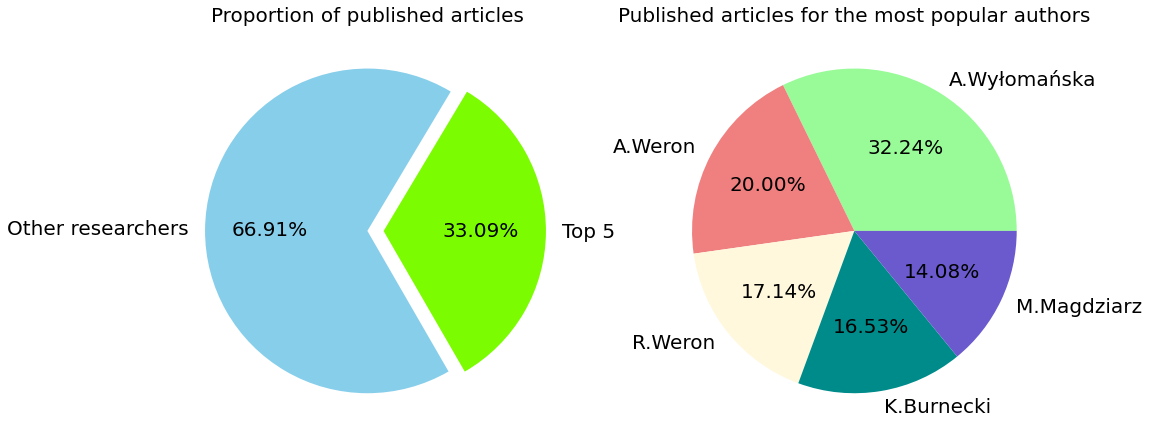

In [29]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 2)

pie_vars = five_authors.keys()
pie_values = five_authors.values()
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['palegreen', 'lightcoral', 'cornsilk', 'darkcyan', 'slateblue'])
plt.title('Published articles for the most popular authors', fontsize=20)

plt.subplot(1, 2, 1)
pie_vars = ['Top 5', 'Other researchers']
pie_values = [sum(five_authors.values()), len(df)-sum(five_authors.values())]
plt.pie(pie_values, labels=pie_vars, explode=(0.1, 0), startangle=300, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['lawngreen', 'skyblue'])
plt.title('Proportion of published articles', fontsize=20)

In [30]:
list(five_authors.keys())

['A.Wyłomańska', 'A.Weron', 'R.Weron', 'K.Burnecki', 'M.Magdziarz']

In Top 5 authors there are: A.Wyłomańska, A.Weron, R.Weron, K.Burnecki, M.Magdziarz. We can see that 33% of HSC members, who publish articles are in analysed "Top 5" of the group. Other members published 67% of all articles. It means that only specified group of professors published a lot of articles, while some of them restricted only to a few ones. If we analyse that 33% from the first authors who have the most publications, we can see that 32% belongs to A.Wyłomańska.

## Changes in number of publications per year for 5 the most common publicist

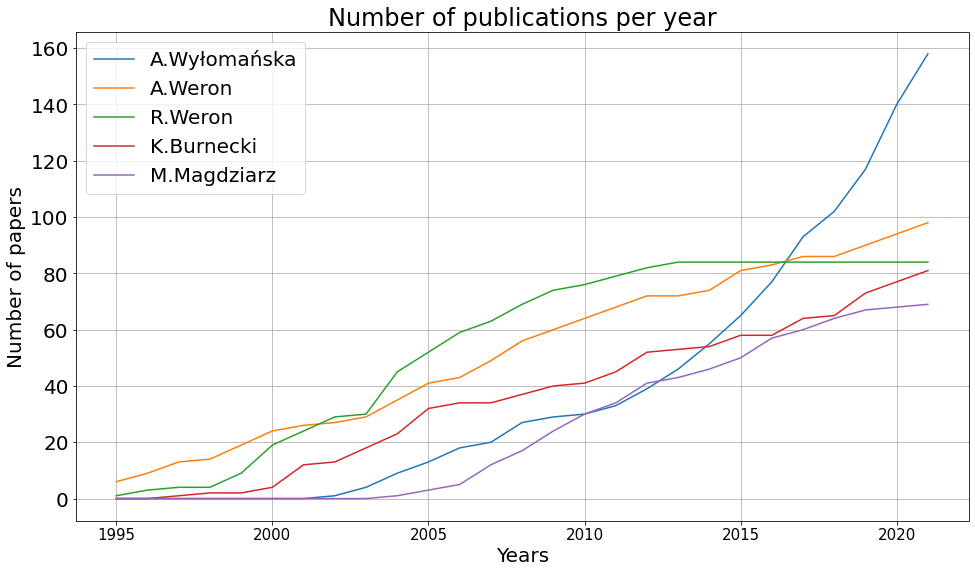

In [31]:
plt.figure(figsize=(16, 9))
for j in range(len(five_authors.keys())):
    x = df[df['Author'] == list(five_authors.keys())[j]].groupby('YearPublished').sum()['HSC'].cumsum().to_dict()
    new_dict = {} 
    for i in range(1995, 2022):
        if i not in list(x.keys()):
            if i-1 > 1995:
                new_dict[i] = new_dict[i-1]
            else:
                new_dict[i] = 0
        else:
            new_dict[i] = x[i]

    plt.plot(new_dict.keys(), new_dict.values(), label=list(five_authors.keys())[j])
    
plt.title('Number of publications per year', fontsize=24)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of papers', fontsize=20)
plt.legend(prop={'size':20})
plt.grid()

During the first year of existance of Hugo Steinhaus Center, A.Weron published 6 articles, and he has published almost 100 articles until today. R.Weron's number of published articles significantly increased in 2003, and became the author with the most publications to 2017. However, he hasn't published any article since 2013, and in 2017 three authors had the same number of publications. Number of publications by K.Burnecki and M.Magdziarz has incresed slowly in time without any oustanding points, which didn't change the slope of this function. Last but not least, A.Wyłomańska published her first paper in 2003 and then he rapidly went up to these days. Her number of publications is significant and valueable for Hugo Steinhaus Center.

## What is the average number of co-authors in one publication per year?

In [32]:
df.groupby(['YearPublished']).mean()['NoOfCoAuthors'].values

array([2.39130435, 2.38461538, 2.61538462, 2.4       , 2.13043478,
       2.71428571, 2.35135135, 1.71428571, 2.46153846, 2.57142857,
       2.66666667, 2.40909091, 2.94285714, 2.6       , 3.375     ,
       2.64705882, 2.87755102, 3.5       , 2.70833333, 3.1754386 ,
       3.77922078, 3.8       , 3.92913386, 3.27027027, 3.96062992,
       3.94308943, 3.98947368])

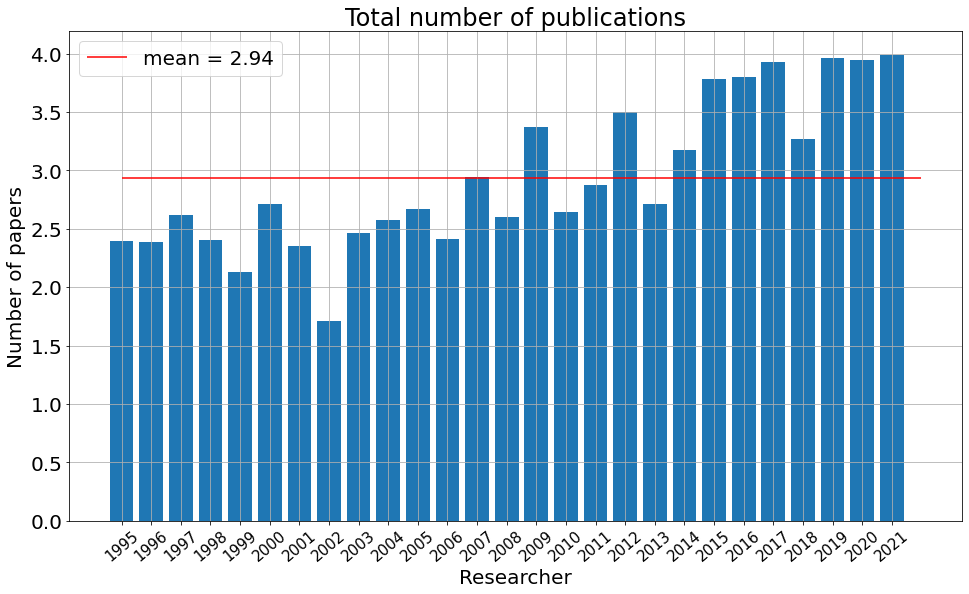

In [33]:
labels = df.groupby(['YearPublished']).mean()['NoOfCoAuthors'].keys()
heights = df.groupby(['YearPublished']).mean()['NoOfCoAuthors'].values

plt.figure(figsize=(16, 9))
plt.hlines(np.mean(heights), 1995, 2022, color='red', label=f'mean = {round(np.mean(heights), 2)}')
plt.bar(labels, heights)
plt.title('Total number of publications', fontsize=24)
plt.xlabel('Researcher', fontsize=20)
plt.xticks(range(1995,2022))
plt.xticks(rotation=40)
plt.ylabel('Number of papers', fontsize=20)
plt.legend(prop={'size':20})
plt.grid()

It is common that for every title of article, there is more than one author who is engaged in creating a good paper. It has a lot of benefits e.g. they can approach the given problem from different points of view. From above plot we can see dependence that this way of publishing articles is more popular now. At the end of XX century the number of co-authors for every article was about 2.5 but during next years, we could see that the average number of co-authors has incresed. Writing common papers with a group of researchers has become a really popular and casual situation.

## Distribution of number co-authors for every publication

In [34]:
d = df.groupby(['NoOfCoAuthors']).count()['HSC'].sample(frac=1)

Text(0.5, 1.0, 'Proportion of number of co-authors')

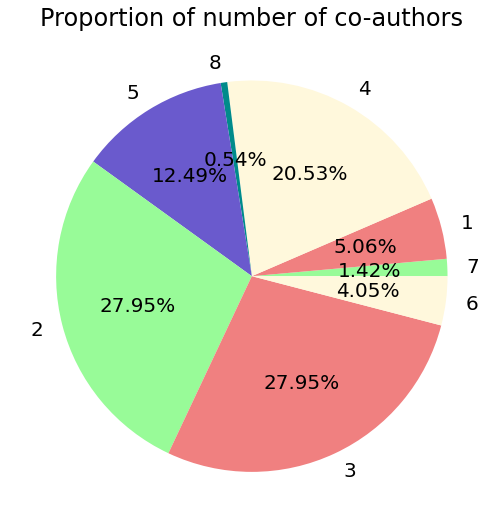

In [35]:
plt.figure(figsize=(16, 9))
pie_vars = d.keys()
pie_values = d.values
plt.pie(pie_values, labels=pie_vars, autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['palegreen', 'lightcoral', 'cornsilk', 'darkcyan', 'slateblue'])
plt.title('Proportion of number of co-authors', fontsize=24)

From above pie chart we can see that the most popular choices in writting articles are writing in a pair or in a group of three scientists. Since 1995 almost more than a half articles have been written by 2 or 3 people. Nevertheless, 4 co-authors choice is also quite common and states for 20% of all articles. Only 5% of articles are written by one person, so it's almost as rare as 6 co-authors. However, they are papers where number of co-authors is relatively huge, e.g. 7 co-authors and 8 co-authors. 

## What article had 8 co-authors?

Let us take a look at the article which has 8 authors in total. From HSC members this article was written by A.Wyłomańska and G.Sikora in 2021. We present the title of this paper below. Other authors don't belong to HSC. 

In [36]:
df[df['NoOfCoAuthors'] == 8]['Title'].max()[:-2]

'Leveraging large-deviation statistics to decipher the stochastic properties of measured trajectories'

In [37]:
df[df['NoOfCoAuthors'] == 8]

,Author,YearPublished,Title,NoOfCoAuthors,HSC
81,S.Thapa,2021,Leveraging large-deviation statistics to decip...,8,False
82,A.Wyłomańska,2021,Leveraging large-deviation statistics to decip...,8,True
83,G.Sikora,2021,Leveraging large-deviation statistics to decip...,8,True
84,C.E.Wagner,2021,Leveraging large-deviation statistics to decip...,8,False
85,D.Krapf,2021,Leveraging large-deviation statistics to decip...,8,False
86,H.Kantz,2021,Leveraging large-deviation statistics to decip...,8,False
87,A.V.Chechkin,2021,Leveraging large-deviation statistics to decip...,8,False
88,R.Metzler,2021,Leveraging large-deviation statistics to decip...,8,False


## Titles from HSC for article titles analysis

How should a good title look like? What does a "good title" mean? Generally, titles of articles should be as neutral as possible, and they shouldn't express emotions. It could make different prejudices for readers before they even start analyse such an article. Let's take a look for sentiment analtysis of all titles of published papers in HSC.

In [38]:
titles = list(df['Title'].values)

In [39]:
eng_stopwords = stopwords.words("english")
Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-]+")

In [40]:
def cleaning_text(titles):
    cleaned_titles = []
    wl=WordNetLemmatizer()
    for title in titles:
        title = title.lower()
        title = Tokenizer.tokenize(title)
        title = [wl.lemmatize(word) for word in title]
        title = [word for word in title if word not in eng_stopwords]
        title = [word for word in title if not word.isnumeric()]

        cleaned_titles.append(title)

    cleaned_titles_combined = [word for sublist in cleaned_titles for word in sublist]
    
    return cleaned_titles_combined

In [41]:
def find_the_most_common_words(comments, limit=15):
    x = Counter(comments).most_common()[:limit]  
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [42]:
cleaned_titles = cleaning_text(titles)

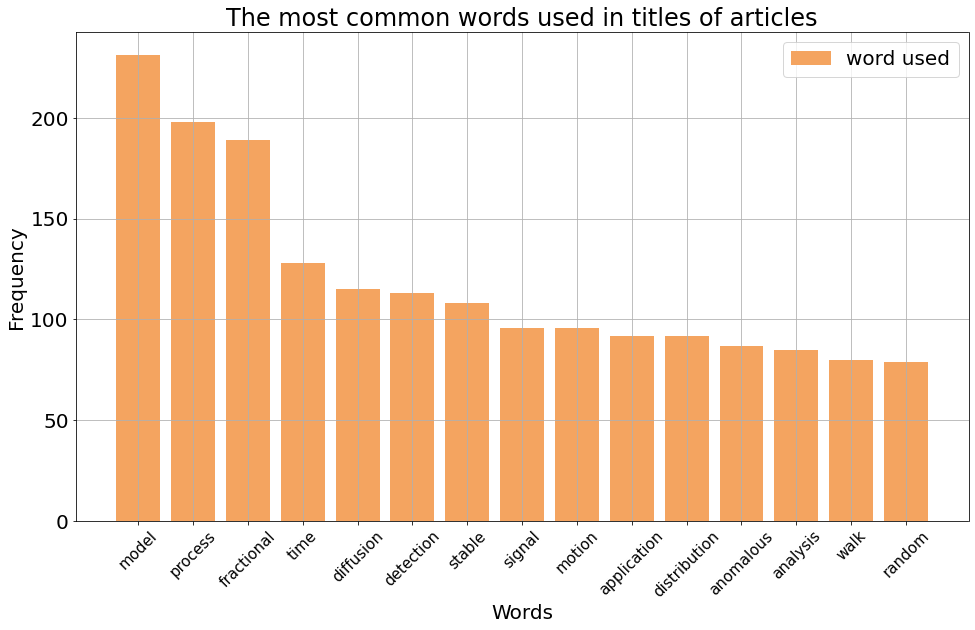

In [43]:
words, occurrences = find_the_most_common_words(cleaned_titles, limit=15)
plt.figure(figsize=(16, 9))
plt.title('The most common words used in titles of articles', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='sandybrown')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

From graph above we can see that the word "model" was used the most number of times. It is an expected result because a lot of mathematical articles are connected to determinig a different type of model. Using mathematical theorems and tools we can evaluate a lot of processes by creating a model with a specified restrictions. Word "process" relates to different calculation by mathematical methods. Every words in strictly connected with a lot of domains of mathematics, which are deeply analysed by HSC members.

In [44]:
def finding_noun_phrases(titles):
    noun_phrases_titles = []
    cleaned_titles = []
    wl=WordNetLemmatizer()
    for title in titles:
        title = title.lower()
        title = Tokenizer.tokenize(title)
        title = [word for word in title if word not in eng_stopwords]
        title = [word for word in title if len(word)>2] 
        title = [word for word in title if not word.isnumeric()]
        title = " ".join(title)
        title = TextBlob(title)
        title = title.noun_phrases   
        noun_phrases_titles.append(title)

    noun_phrases_titles_combined = [word for sublist in noun_phrases_titles for word in sublist]
    
    return noun_phrases_titles_combined

In [45]:
def find_the_most_common_noun_phrases(titles, limit=15):
    x = Counter(titles).most_common()[:limit] 
    x = [phrase for phrase in x if phrase[0] != 'gon na']
    x = [phrase for phrase in x if len(phrase[0].split(' '))==2]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

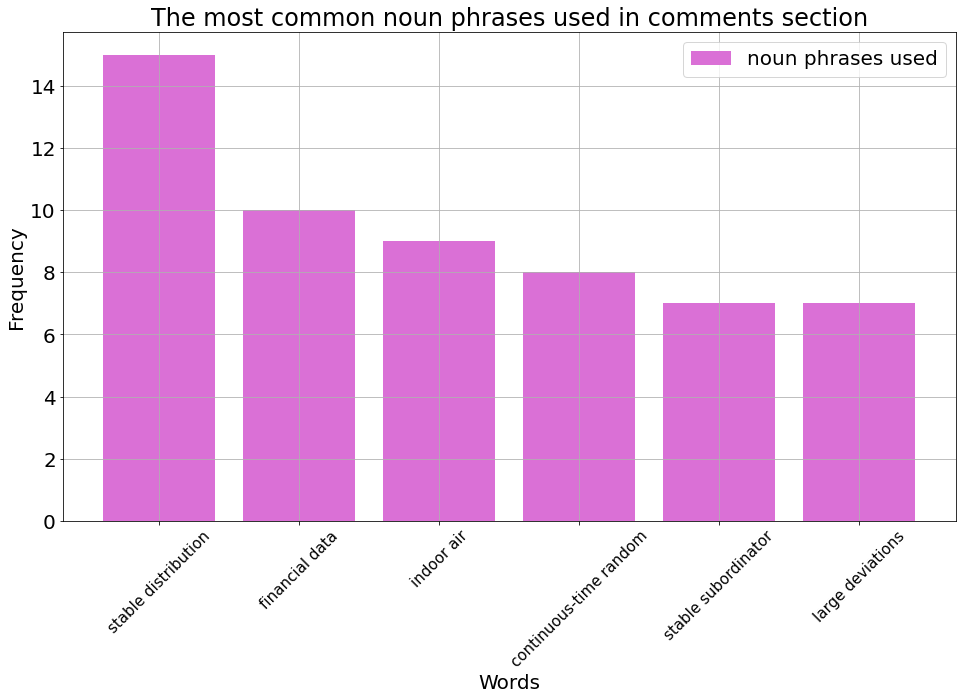

In [46]:
words, occurrences = find_the_most_common_noun_phrases(finding_noun_phrases(titles))
plt.figure(figsize=(16, 9))
plt.title('The most common noun phrases used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='orchid')
plt.legend(['noun phrases used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

One of the most common phrase is "stable distribution" which is a distribution that is to be stable if a linear combination of two independent random variables with this distribution has the same distribution, up to location and scale parameters. A lot of HSC members investigate stable distributions and their properties. It is worth mentioning that for every common phrase which was found and presented on the graph above, there is at least one article in which A.Wyłomańska is present as a co-author.

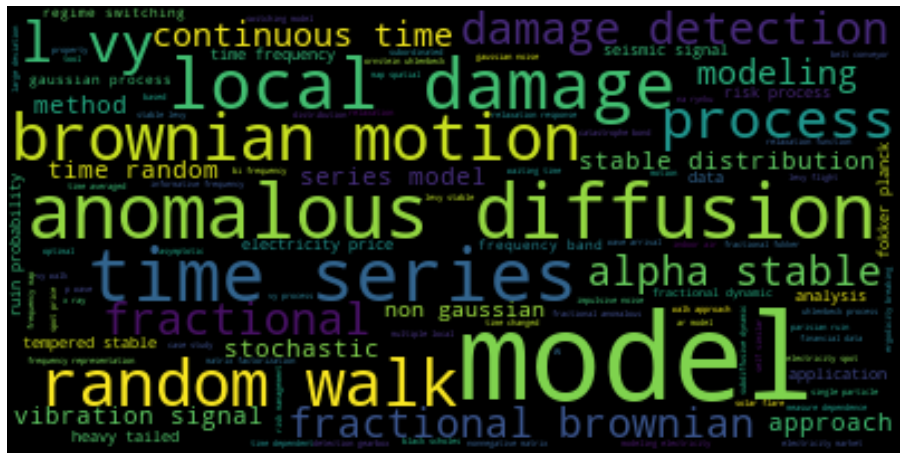

In [47]:
wordcloud = WordCloud(stopwords=eng_stopwords).generate(" ".join(cleaned_titles))
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
analyser = SentimentIntensityAnalyzer()

In [49]:
negative, neutral, positive, compound = [], [], [], []
for title in titles:
    negative.append(analyser.polarity_scores(title)['neg'])
    neutral.append(analyser.polarity_scores(title)['neu'])
    positive.append(analyser.polarity_scores(title)['pos'])
    compound.append(analyser.polarity_scores(title)['compound'])

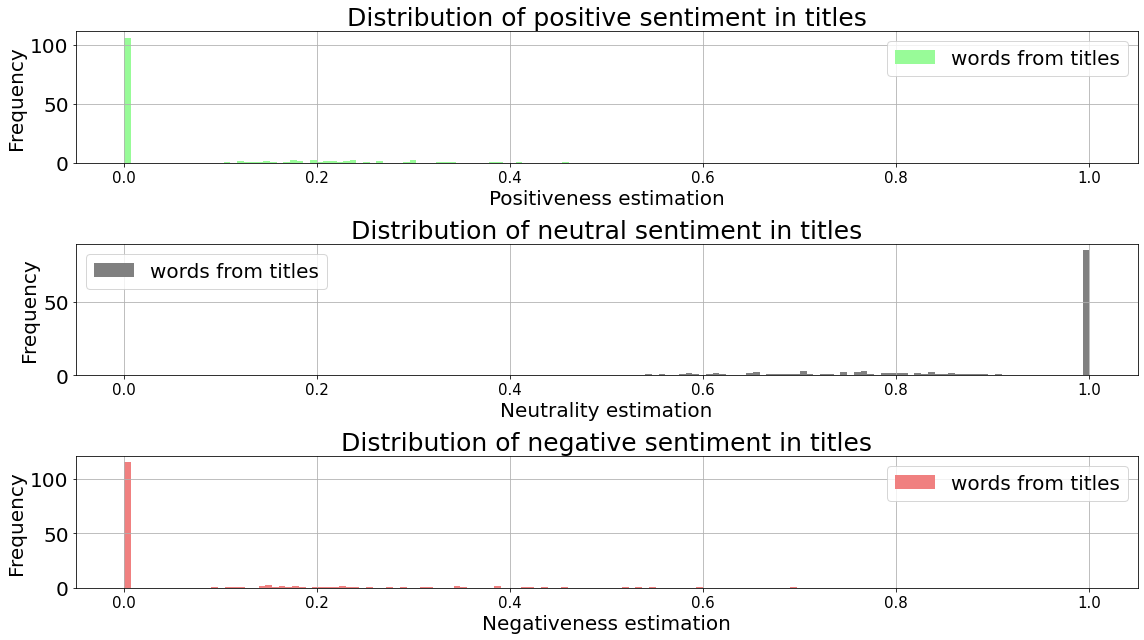

In [50]:
plt.figure(figsize=(16, 9))
plt.subplot(3, 1, 1)
plt.title('Distribution of positive sentiment in titles', fontsize=25)
plt.xlabel('Positiveness estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(positive, bins=100, density=True, color='palegreen')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['words from titles'], prop={'size': 20})

plt.subplot(3, 1, 2)
plt.title('Distribution of neutral sentiment in titles', fontsize=25)
plt.xlabel('Neutrality estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(neutral, bins=100, density=True, color='grey')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['words from titles'], prop={'size': 20})

plt.subplot(3, 1, 3)
plt.title('Distribution of negative sentiment in titles', fontsize=25)
plt.xlabel('Negativeness estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(negative, bins=100, density=True, color='lightcoral')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['words from titles'], prop={'size': 20})


plt.tight_layout()

Text(0.5, 1.0, 'Sentiment analysis')

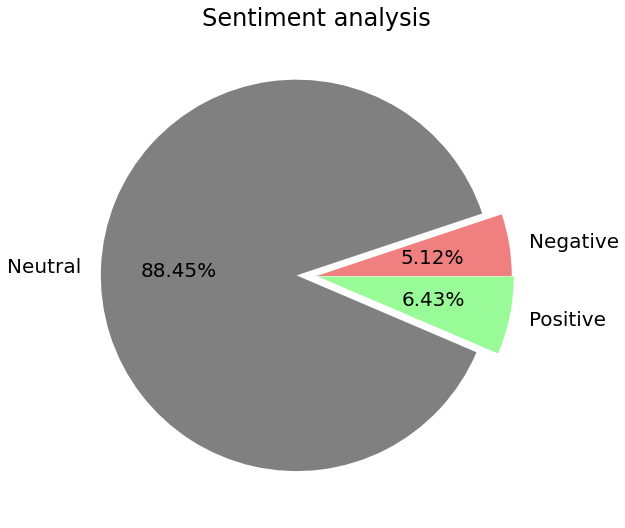

In [51]:
plt.figure(figsize=(16, 9))
pie_vars = ['Negative', 'Neutral', 'Positive']
pie_values = [[sum(negative), sum(positive)]]
plt.pie([sum(negative), sum(neutral), sum(positive)], explode=(0, 0.1, 0.01), labels=pie_vars,autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['lightcoral', 'grey', 'palegreen'])
plt.title('Sentiment analysis', fontsize=24)

Almost every title from our dataframe is considered as neutral, so we could say that titles are well-defined. They're classified as neutral due to large number of mathematical words and phrases.

## Professor A.Wyłomańska articles analysis

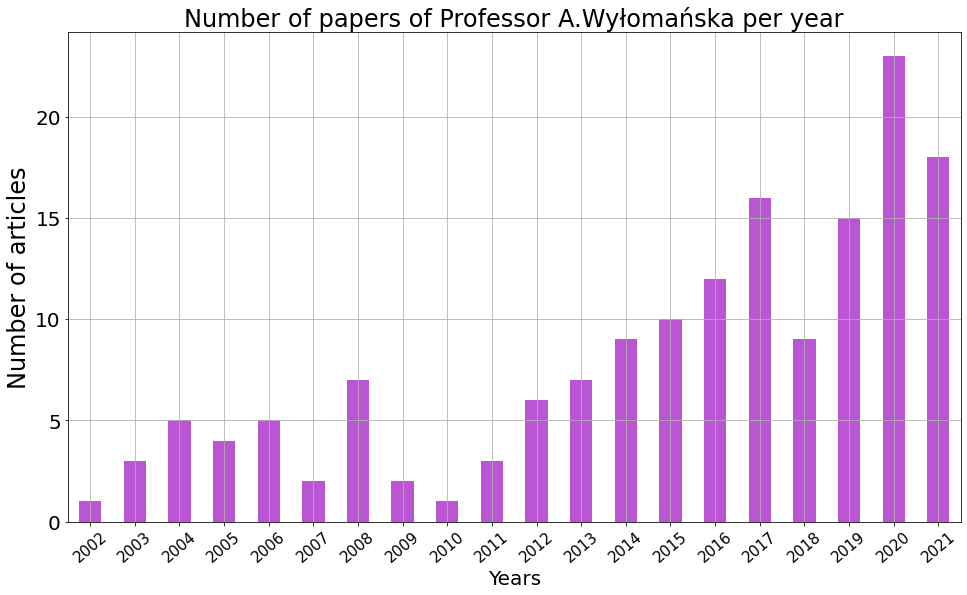

In [52]:
plt.figure(figsize=(16, 9))
df[df['Author'] == 'A.Wyłomańska'].groupby(['YearPublished']).count()['HSC'].plot.bar(color='mediumorchid')
plt.ylabel('Number of articles', fontsize=24)
plt.xlabel('Years', fontsize=20)
plt.title('Number of papers of Professor A.Wyłomańska per year', fontsize=24)
plt.xticks(rotation=40)
plt.grid()

From graph above, we can see two periods of publishing articles. Firstly, since 2010 Professor A.Wyłomańska has published about 5 articles per year, and after 2010 number of published articles has started increasing linearly to 2017. Next two years were less plentiful in articles, but after this time in 2020 she published more than 20 articles. She became a scientist with the highest number of research papers in Hugo Steinhaus Center.

In [53]:
titles = list(df[df['Author'] == 'A.Wyłomańska']['Title'].values)

## Sentiment analysis of titles of articles Prof. A.Wyłomańska has written

In [54]:
eng_stopwords = stopwords.words("english")
Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-]+")

In [55]:
def cleaning_text(titles):
    cleaned_titles = []
    wl=WordNetLemmatizer()
    for title in titles:
        title = title.lower()
        title = Tokenizer.tokenize(title)
        title = [word for word in title if word not in eng_stopwords]
        title = [word for word in title if not word.isnumeric()]

        cleaned_titles.append(title)

    cleaned_titles_combined = [word for sublist in cleaned_titles for word in sublist]
    
    return cleaned_titles_combined

In [56]:
def find_the_most_common_words(comments, limit=15):
    x = Counter(comments).most_common()[:limit]  
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [57]:
cleaned_titles = cleaning_text(titles)

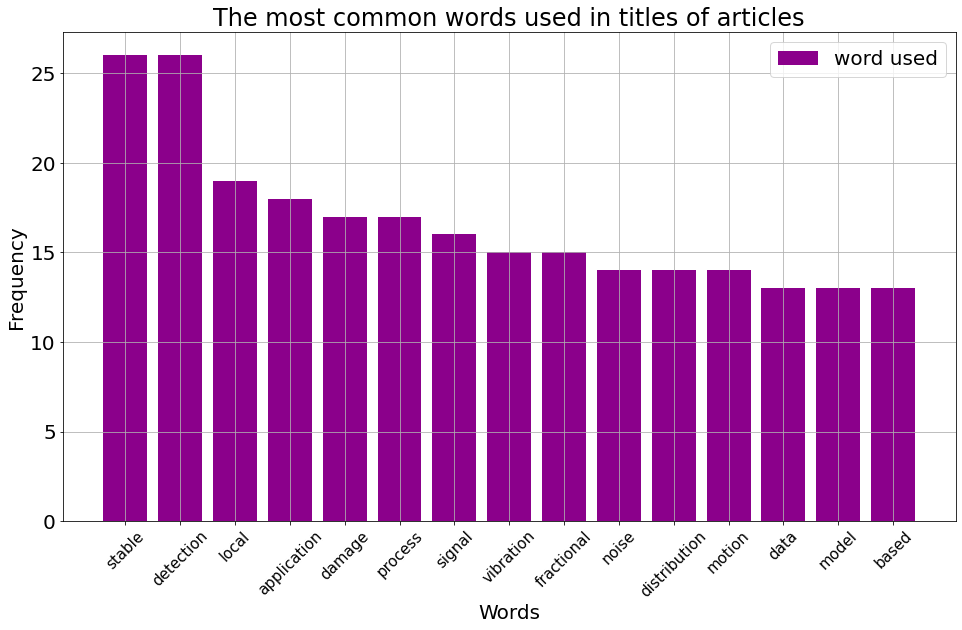

In [58]:
words, occurrences = find_the_most_common_words(cleaned_titles, limit=15)
plt.figure(figsize=(16, 9))
plt.title('The most common words used in titles of articles', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='darkmagenta')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

A.Wyłomańska's area of interest relates to: time series analysis, stochastic modeling, and statistical analysis of real data (especially technical data related to mining industry, indoor air quality and financial time series). She cooperates with industrial companies, especially from mining industry. From obtained words, we can see that "stable" and "detection" are the most common words in her titles. It reflects her area of interest with time series analysis. Similarly for "process", "fractional" and "noise" which are connected with stochastic modeling.  

In [59]:
def finding_noun_phrases(titles):
    noun_phrases_titles = []
    cleaned_titles = []
    wl=WordNetLemmatizer()
    for title in titles:
        title = title.lower()
        title = Tokenizer.tokenize(title)
        title = [word for word in title if word not in eng_stopwords]
        title = [word for word in title if len(word)>2] 
        title = [word for word in title if not word.isnumeric()]
        title = " ".join(title)
        title = TextBlob(title)
        title = title.noun_phrases   
        noun_phrases_titles.append(title)

    noun_phrases_titles_combined = [word for sublist in noun_phrases_titles for word in sublist]
    
    return noun_phrases_titles_combined

In [60]:
def find_the_most_common_noun_phrases(titles, limit=15):
    x = Counter(titles).most_common()[:limit] 
    x = [phrase for phrase in x if phrase[0] != 'gon na']
    x = [phrase for phrase in x if len(phrase[0].split(' '))==2]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

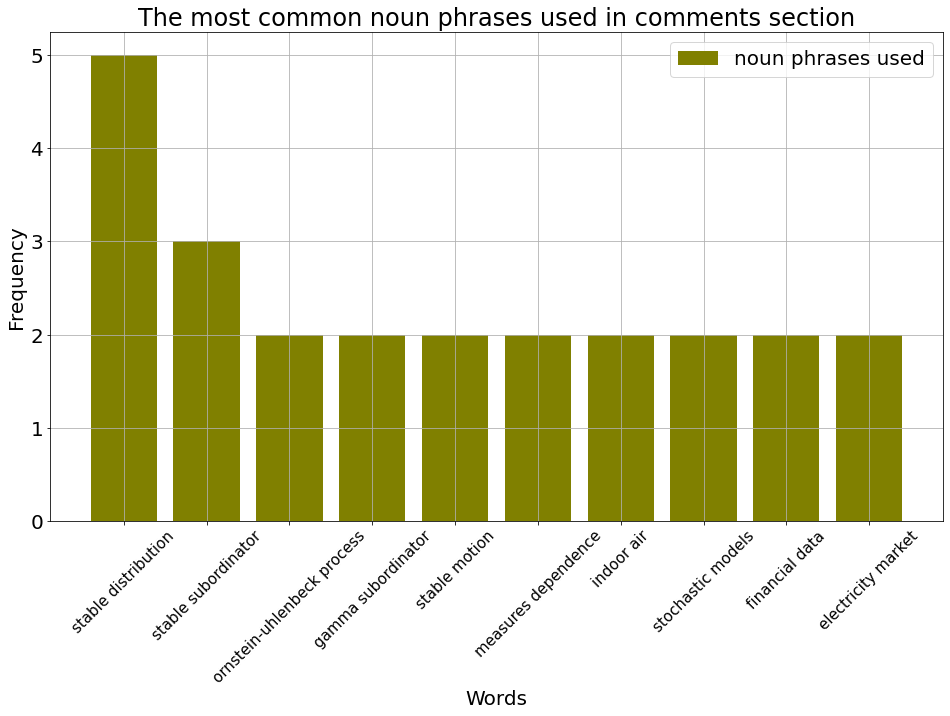

In [61]:
words, occurrences = find_the_most_common_noun_phrases(finding_noun_phrases(titles))
plt.figure(figsize=(16, 9))
plt.title('The most common noun phrases used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='olive')
plt.legend(['noun phrases used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

The most common phrases words from A.Wyłomańska titles are connected with time series analysis and stochastic modeling, which are part of her interest. We can see that topics of her papers are similar to her fields of researchers, which is a good sign.

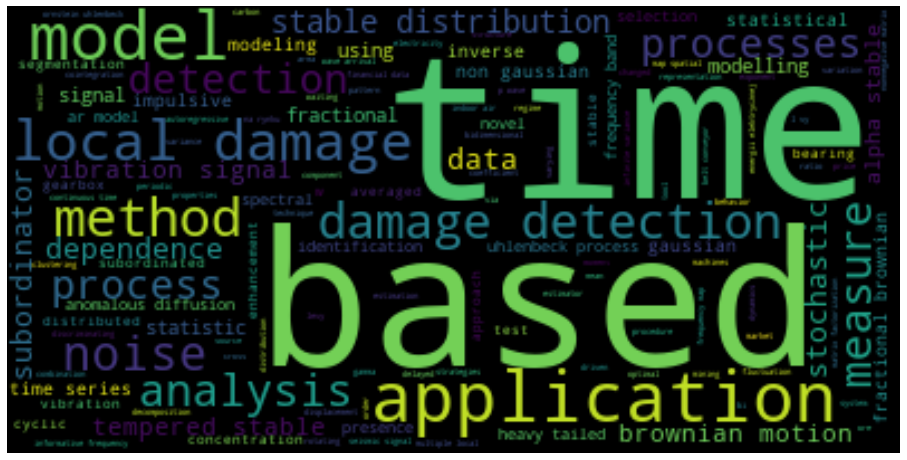

In [62]:
wordcloud = WordCloud(stopwords=eng_stopwords).generate(" ".join(cleaned_titles))
plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
analyser = SentimentIntensityAnalyzer()

In [64]:
negative, neutral, positive, compound = [], [], [], []
for title in titles:
    negative.append(analyser.polarity_scores(title)['neg'])
    neutral.append(analyser.polarity_scores(title)['neu'])
    positive.append(analyser.polarity_scores(title)['pos'])
    compound.append(analyser.polarity_scores(title)['compound'])

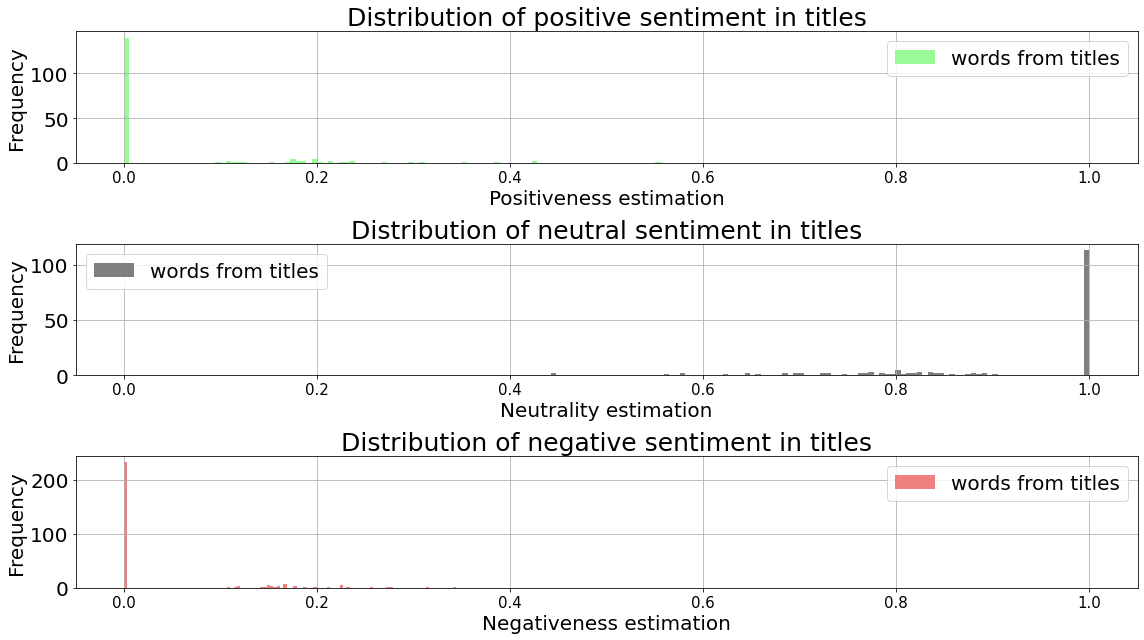

In [65]:
plt.figure(figsize=(16, 9))
plt.subplot(3, 1, 1)
plt.title('Distribution of positive sentiment in titles', fontsize=25)
plt.xlabel('Positiveness estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(positive, bins=100, density=True, color='palegreen')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['words from titles'], prop={'size': 20})

plt.subplot(3, 1, 2)
plt.title('Distribution of neutral sentiment in titles', fontsize=25)
plt.xlabel('Neutrality estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(neutral, bins=100, density=True, color='grey')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['words from titles'], prop={'size': 20})

plt.subplot(3, 1, 3)
plt.title('Distribution of negative sentiment in titles', fontsize=25)
plt.xlabel('Negativeness estimation', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.hist(negative, bins=100, density=True, color='lightcoral')
plt.grid()
plt.xlim([-0.05, 1.05])
plt.legend(['words from titles'], prop={'size': 20})


plt.tight_layout()

Text(0.5, 1.0, 'Sentiment analysis')

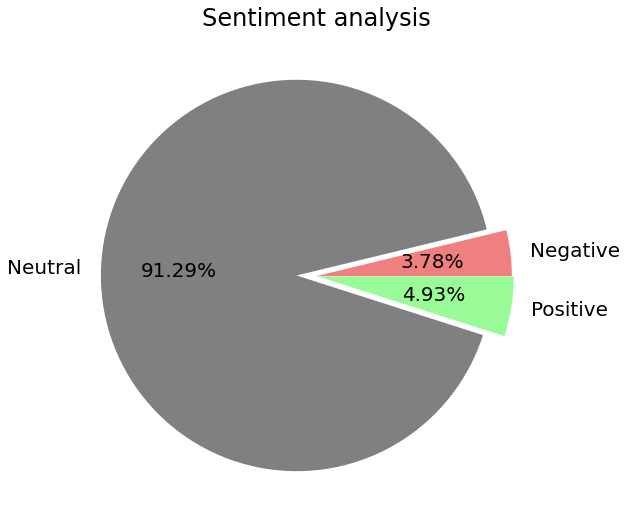

In [66]:
plt.figure(figsize=(16, 9))
pie_vars = ['Negative', 'Neutral', 'Positive']
pie_values = [[sum(negative), sum(positive)]]
plt.pie([sum(negative), sum(neutral), sum(positive)], explode=(0, 0.1, 0.01), labels=pie_vars,autopct='%1.2f%%', textprops={'fontsize': 20}, colors=['lightcoral', 'grey', 'palegreen'])
plt.title('Sentiment analysis', fontsize=24)

Almost every title from of A.Wyłomańska articles is considered as neutral, so we could say that title are well-defined. They're classified as neutral due to large number of mathematical words and phrases.

# Conclusions

I have downloaded data about papers from Hugo Steinhaus Center website. There are 546 papers and 280 authors. Using scrapped information, I have created a dataframe for every author, containing title of an article, year of publications, membership of HSC and the number of co-authors. Then I have taken a look at some statisics: what is the number of HSC members, who wrote the most papers, and with whom. I have calculated the average number of co-authors and presented numbers of articles in time for the most common authors from HSC. Finally, A.Wyłomańska have had the biggest impact on HSC because she published the most papers since 2003 year. Her extraordinary knowledge is used for creating a lot of articles with different topic. Moreover, her topics are well-defined, they don't have an opinion inside, so they satisfy the conditions for good topic of article. 